In [1]:
from sklearn.metrics import *
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator

from final_models_explainability.get_predictions import *

In [2]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort-holdout"

In [3]:
subject_list = find_subjects_parallel(data_path)
    

Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort-holdout/idaSearch_3_19_2025.csv']


In [4]:
for subject in subject_list:

    subject.data = {}

    # Group
    mapping = {
        'CN': 0,
        'MCI': 1,
    }

    # Get the value of the mapping, -1 if not found
    subject.data['research_group'] = mapping.get(subject.subject_metadata['Research Group'].iloc[0], -1)

    # Cloud
    subject.data['lhcampus_pointcloud_aligned'] = np.load(os.path.join(subject.path, 'Left-Hippocampus_aligned_cropped_mesh_downsampledcloud.npy'))

    # Volumes
    volume_col = subject.aseg_stats['Volume_mm3']
    volume_col_normalised = volume_col / volume_col.sum() * 1000
    struct_name_col = subject.aseg_stats['StructName']
    
    subject.data['volumes'] = np.array(volume_col_normalised)
    
    subject.data['struct_names'] = np.array(struct_name_col)

    # Scores
    mmse = subject.subject_metadata['MMSE Total Score'].iloc[0]
    gdscale = subject.subject_metadata['GDSCALE Total Score'].iloc[0]
    faq = subject.subject_metadata['FAQ Total Score'].iloc[0]
    npiq = subject.subject_metadata['NPI-Q Total Score'].iloc[0]

    subject.data['scores'] = [mmse, gdscale, faq, npiq]

    subject.data['score_names'] = ['MMSE Total Score', 'GDSCALE Total Score', 'FAQ Total Score', 'NPI-Q Total Score']

In [5]:
print(f"Total holdout subjects: {len(subject_list)}\n")
print(f"Total CN: {len([subject.data['research_group'] for subject in subject_list if subject.data['research_group'] == 0])}\n")
print(f"Total MCI: {len([subject.data['research_group'] for subject in subject_list if subject.data['research_group'] == 1])}\n")

Total holdout subjects: 35

Total CN: 12

Total MCI: 23



## Evaluate pointnet

In [6]:
true = []
pred_probs = []
pred_classes = []
data = []
attributions_list = []

# Run multiple times to account for randomness
for i in range(5):

    for subject in tqdm(subject_list, total=len(subject_list)):

        pred_class, output, attributions = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cuda')

        data.append(subject.data['lhcampus_pointcloud_aligned'])

        attributions_list.append(attributions)

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/pointnet_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data, attributions_list=attributions_list)



100%|██████████| 35/35 [02:04<00:00,  3.55s/it]


              precision    recall  f1-score   support

          CN       0.50      0.72      0.59        60
         MCI       0.81      0.63      0.71       115

    accuracy                           0.66       175
   macro avg       0.65      0.67      0.65       175
weighted avg       0.70      0.66      0.67       175

roc_auc: 0.6713768115942029


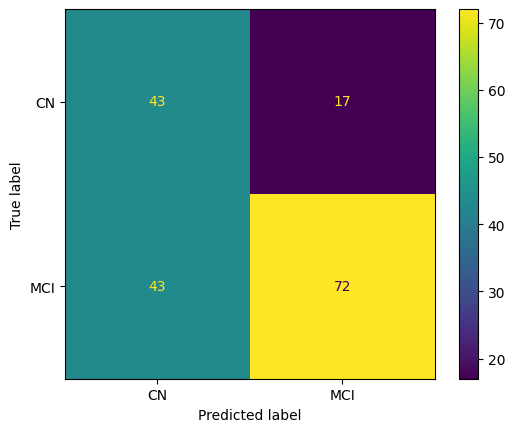

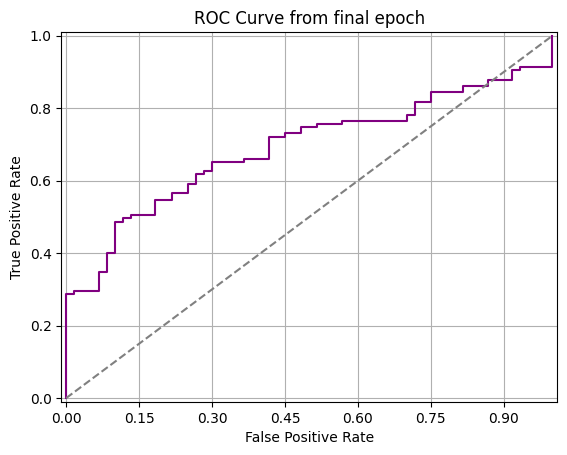

In [7]:
results = np.load('pointnet_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']
attributions_list= results['attributions_list']


report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['CN','MCI'])

conf_matrix_disp.plot()

plt.show()

fig, ax = plt.subplots()

ax.plot(fpr, tpr, color='purple')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_title('ROC Curve from final epoch')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)
ax.grid(True)
ax.xaxis.set_major_locator(MaxNLocator(integer=False))
plt.show()

## Evaluate volumes gbdt

In [8]:
true = []
pred_probs = []
pred_classes = []
data = []

for subject in subject_list:

    pred_class, output, _ = get_volumes_prediction(subject.data['volumes'])

    data.append(subject.data['volumes'])

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/volumes_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data, attributions_list=attributions_list)

              precision    recall  f1-score   support

          CN       0.54      0.58      0.56        12
         MCI       0.77      0.74      0.76        23

    accuracy                           0.69        35
   macro avg       0.66      0.66      0.66        35
weighted avg       0.69      0.69      0.69        35

roc_auc: 0.661231884057971


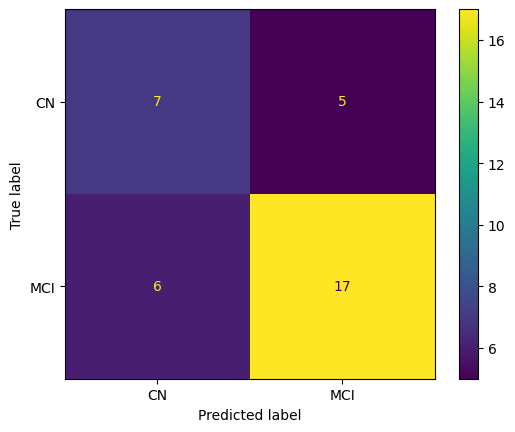

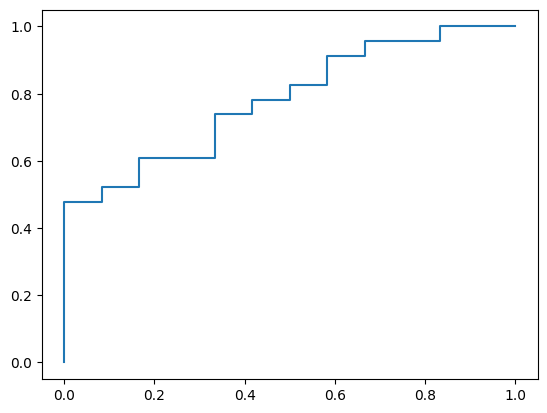

In [9]:
results = np.load('volumes_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']
attributions_list= results['attributions_list']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['CN','MCI'])

conf_matrix_disp.plot()

plt.show()

plt.plot(fpr, tpr)

plt.show()

## Evaluate scores gbdt

In [10]:
true = []
pred_probs = []
pred_classes = []
data = []

for subject in subject_list:

    pred_class, output = get_scores_prediction(subject.data['scores'])

    data.append(subject.data['scores'])

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scores_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data, attributions_list=attributions_list)

              precision    recall  f1-score   support

          CN       0.59      0.83      0.69        12
         MCI       0.89      0.70      0.78        23

    accuracy                           0.74        35
   macro avg       0.74      0.76      0.74        35
weighted avg       0.79      0.74      0.75        35

roc_auc: 0.7644927536231885


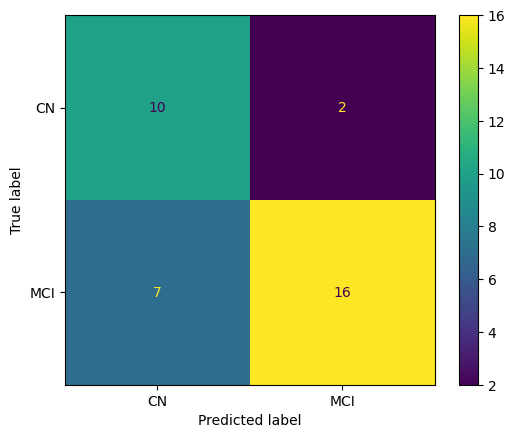

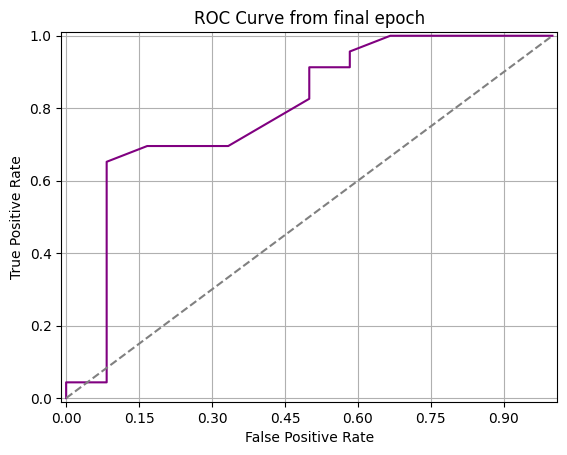

In [11]:
results = np.load('scores_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']
attributions_list= results['attributions_list']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['CN','MCI'])

conf_matrix_disp.plot()

plt.show()

fig, ax = plt.subplots()

ax.plot(fpr, tpr, color='purple')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_title('ROC Curve from final epoch')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)
ax.grid(True)
ax.xaxis.set_major_locator(MaxNLocator(integer=False))
plt.show()

# Evaluate averave ensemble without scores

In [12]:
true = []
pred_probs = []
pred_classes = []
data = []

# Run multiple times to account for randomness
for i in range(5):

    for subject in tqdm(subject_list, total=len(subject_list)):

        pointnet_pred_class, pointnet_output, attributions = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cuda')

        volumes_pred_class, volumes_output, shap_values = get_volumes_prediction(subject.data['volumes'], subject.data['struct_names'])

        pred_class, output = get_ensemble_prediction_avg(pointnet_output, volumes_output, None, scores=False)

        data.append(subject.data['volumes'])

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/avgensemblenoscores_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data)

100%|██████████| 35/35 [01:46<00:00,  3.06s/it]


              precision    recall  f1-score   support

          CN       0.53      0.67      0.59        12
         MCI       0.80      0.70      0.74        23

    accuracy                           0.69        35
   macro avg       0.67      0.68      0.67        35
weighted avg       0.71      0.69      0.69        35

roc_auc: 0.6811594202898551


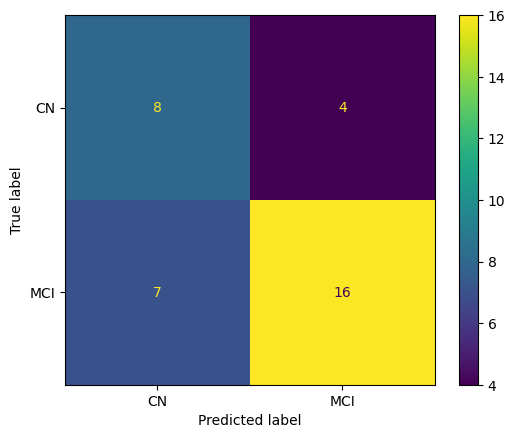

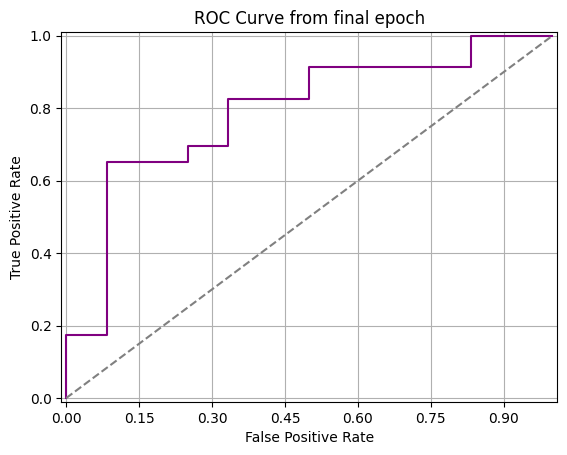

In [13]:
results = np.load('avgensemble_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']
attributions_list= results['attributions_list']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['CN','MCI'])

conf_matrix_disp.plot()

plt.show()

fig, ax = plt.subplots()

ax.plot(fpr, tpr, color='purple')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_title('ROC Curve from final epoch')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)
ax.grid(True)
ax.xaxis.set_major_locator(MaxNLocator(integer=False))
plt.show()

## Evaluate maxprob ensemble without scores

In [14]:
true = []
pred_probs = []
pred_classes = []
data = []
models_used = []

# Run multiple times to account for randomness
for i in range(5):

    for subject in tqdm(subject_list, total=len(subject_list)):

        pointnet_pred_class, pointnet_output, attributions = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cuda')

        volumes_pred_class, volumes_output, shap_values = get_volumes_prediction(subject.data['volumes'], subject.data['struct_names'])

        pred_class, output, index = get_ensemble_prediction_maxprob((pointnet_pred_class, pointnet_output), (volumes_pred_class, volumes_output), None, scores=False)

        models_used.append(index)

        data.append(subject.data['volumes'])

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

print(np.unique(models_used, return_counts=True))

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/maxprobensemblenoscores_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data)

100%|██████████| 35/35 [01:48<00:00,  3.11s/it]

(array([0, 1]), array([ 65, 110]))


              precision    recall  f1-score   support

          CN       0.62      0.42      0.50        12
         MCI       0.74      0.87      0.80        23

    accuracy                           0.71        35
   macro avg       0.68      0.64      0.65        35
weighted avg       0.70      0.71      0.70        35

roc_auc: 0.6431159420289855


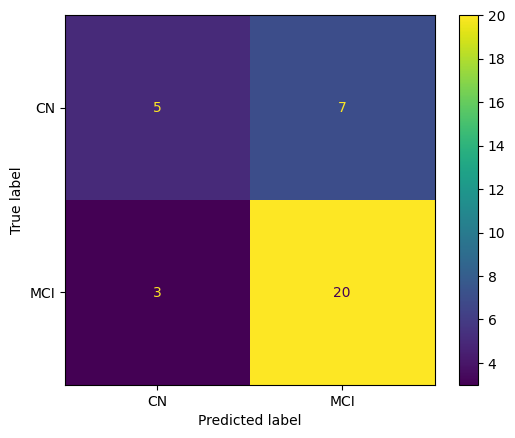

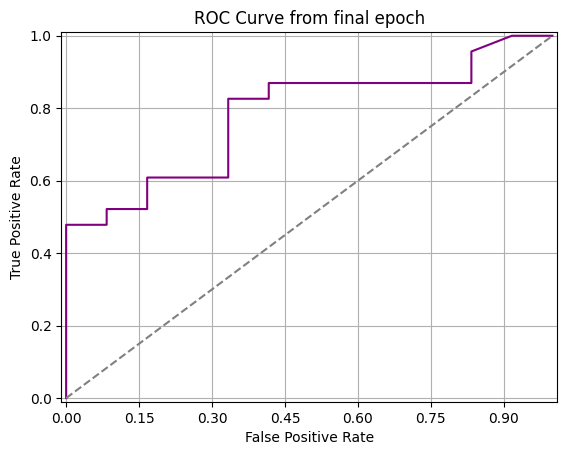

In [15]:
results = np.load('maxprobensemble_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['CN','MCI'])

conf_matrix_disp.plot()

plt.show()

fig, ax = plt.subplots()

ax.plot(fpr, tpr, color='purple')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_title('ROC Curve from final epoch')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)
ax.grid(True)
ax.xaxis.set_major_locator(MaxNLocator(integer=False))
plt.show()

# Evaluate averave ensemble with scores

In [16]:
true = []
pred_probs = []
pred_classes = []
data = []

# Run multiple times to account for randomness
for i in range(5):

    for subject in tqdm(subject_list, total=len(subject_list)):

        pointnet_pred_class, pointnet_output, attributions = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cuda')

        volumes_pred_class, volumes_output, shap_values = get_volumes_prediction(subject.data['volumes'], subject.data['struct_names'])

        scores_pred_class, scores_output = get_scores_prediction(subject.data['scores'])

        pred_class, output = get_ensemble_prediction_avg(pointnet_output, volumes_output, scores_output, scores=True)

        data.append(subject.data['volumes'])

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/avgensemble_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data)

100%|██████████| 35/35 [01:45<00:00,  3.03s/it]


              precision    recall  f1-score   support

          CN       0.56      0.67      0.61        60
         MCI       0.81      0.72      0.76       115

    accuracy                           0.70       175
   macro avg       0.68      0.69      0.68       175
weighted avg       0.72      0.70      0.71       175

roc_auc: 0.6942028985507248


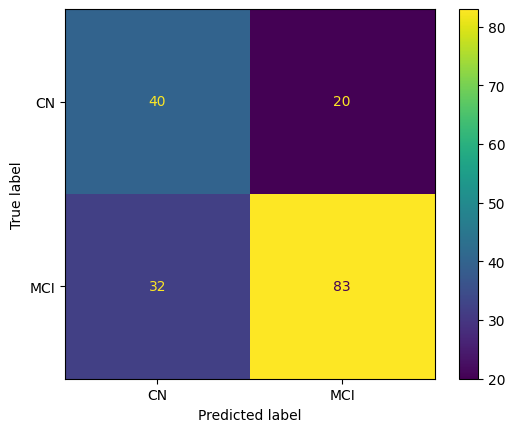

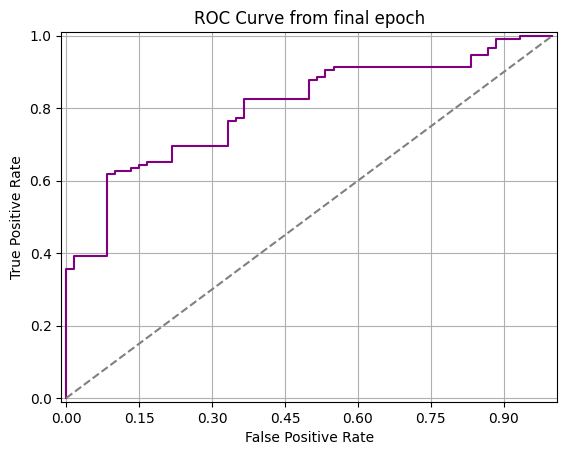

In [18]:
results = np.load('avgensemble_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['CN','MCI'])

conf_matrix_disp.plot()

plt.show()

fig, ax = plt.subplots()

ax.plot(fpr, tpr, color='purple')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_title('ROC Curve from final epoch')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)
ax.grid(True)
ax.xaxis.set_major_locator(MaxNLocator(integer=False))
plt.show()

## Evaluate maxprob ensemble with scores

In [19]:
true = []
pred_probs = []
pred_classes = []
data = []
models_used = []

# Run multiple times to account for randomness
for i in range(5):

    for subject in tqdm(subject_list, total=len(subject_list)):

        pointnet_pred_class, pointnet_output, attributions = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cuda')

        volumes_pred_class, volumes_output, shap_values = get_volumes_prediction(subject.data['volumes'], subject.data['struct_names'])

        scores_pred_class, scores_output = get_scores_prediction(subject.data['scores'])

        pred_class, output, index = get_ensemble_prediction_maxprob((pointnet_pred_class, pointnet_output), (volumes_pred_class, volumes_output), (scores_pred_class, scores_output), scores=True)

        models_used.append(index)

        data.append(subject.data['volumes'])

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

print(np.unique(models_used, return_counts=True))

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/maxprobensemble_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data)

100%|██████████| 35/35 [02:02<00:00,  3.50s/it]

(array([0, 1, 2]), array([ 13, 105,  57]))


              precision    recall  f1-score   support

          CN       0.62      0.42      0.50        60
         MCI       0.74      0.87      0.80       115

    accuracy                           0.71       175
   macro avg       0.68      0.64      0.65       175
weighted avg       0.70      0.71      0.70       175

roc_auc: 0.6431159420289855


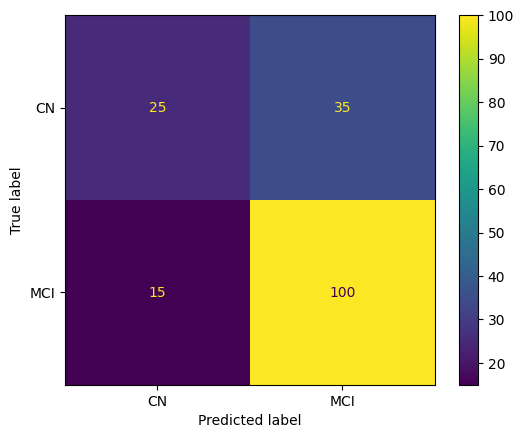

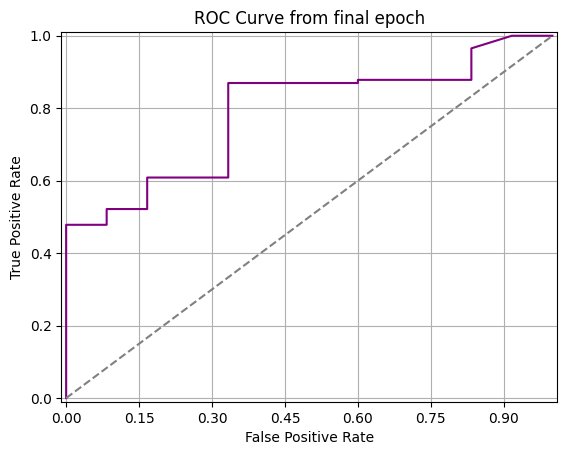

In [20]:
results = np.load('maxprobensemble_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['CN','MCI'])

conf_matrix_disp.plot()

plt.show()

fig, ax = plt.subplots()

ax.plot(fpr, tpr, color='purple')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_title('ROC Curve from final epoch')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)
ax.grid(True)
ax.xaxis.set_major_locator(MaxNLocator(integer=False))
plt.show()